In [237]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import copy
from IPython.display import display
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# disable chained assignments
pd.options.mode.chained_assignment = None

In [238]:
data_activity_dir = "../data/acf/df_activity_30m.txt"
data_temperature_dir = "../data/acf/t001_1h.txt"

df_activity_30m = pd.read_csv(
    data_activity_dir,
    delimiter=",",
    header=0,
    parse_dates=True,
)

df_t001_1h = pd.read_csv(
    data_temperature_dir,
    delimiter=",",
    header=0,
    parse_dates=True,
)

df_activity_30m["DateTime_ISO8601"] = pd.to_datetime(df_activity_30m["DateTime_ISO8601"], format="ISO8601")
df_t001_1h["DateTime_ISO8601"] = pd.to_datetime(df_t001_1h["DateTime_ISO8601"], format="ISO8601")

##### ÜBUNG: AUTOKORRELATIONSFUNKTION 

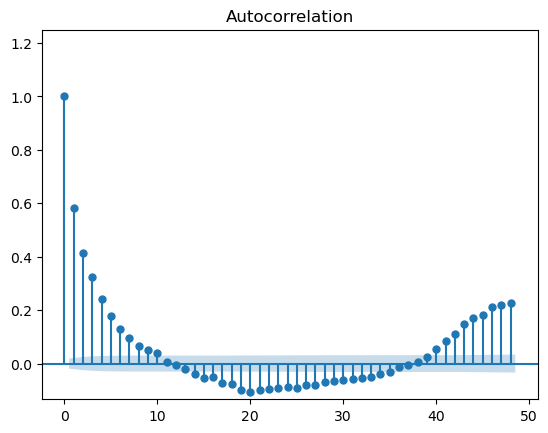

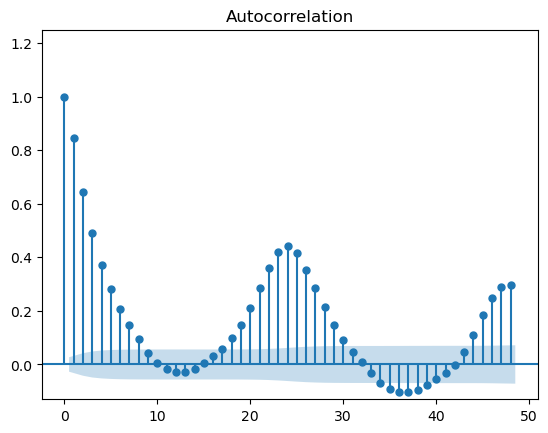

In [239]:
_ = plot_acf(df_activity_30m["Activity"], lags=48, auto_ylims=True)
_ = plot_acf(df_t001_1h["Value_num"], lags=48, auto_ylims=True)

##### ÜBUNG: KLASSISCHE DEKOMPOSITION

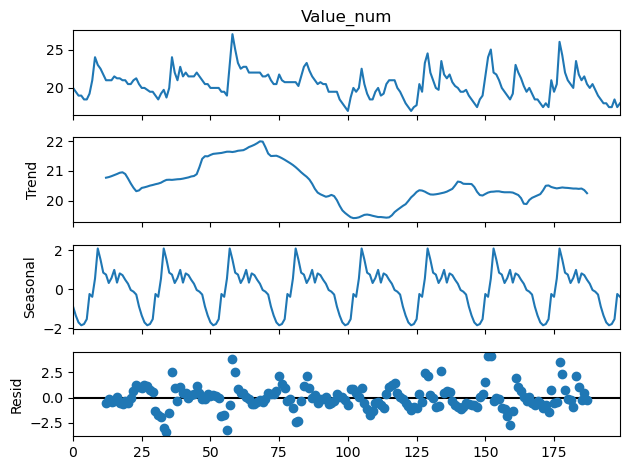

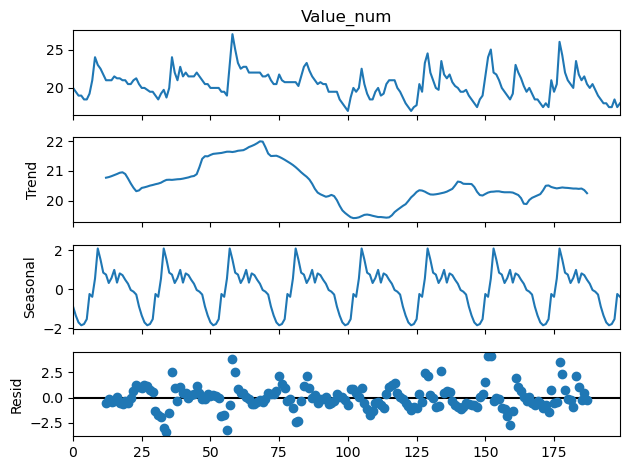

In [240]:
decomposed = seasonal_decompose(df_t001_1h["Value_num"][:200], model="additive", period=24)
decomposed.plot()

##### ÜBUNG: EINFACHE VORHERSAGE (NAIVE)
- Laden Sie aus ILIAS die Datensätze df_activity_30m und t001_1h herunter.
- Teilen Sie die Daten in 80% Trainingsdaten und 20% Testdaten auf.
- Implementieren Sie die Vorhersagemodelle Naive und Seasonal-Naive.
- Visualisieren Sie die Zeitseriendaten zusammen mit den Vorhersagen auf den Testdaten.
- Berechnen Sie den RMSE (Root Mean Squared Error) für beide Modelle.

In [241]:
# Calculate Root Mean Squared Error (RMSE)
def calculate_rmse(test: pd.DataFrame, train: pd.DataFrame) -> float:
    return np.sqrt(mean_squared_error(test, train))


# all := 0
range_limit = 300

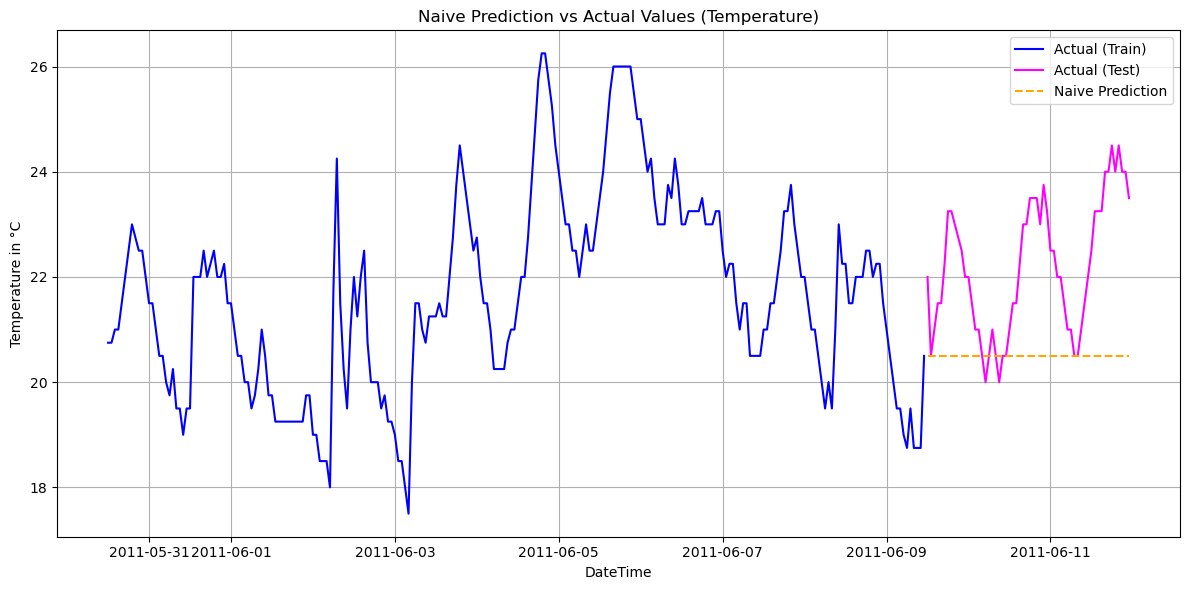

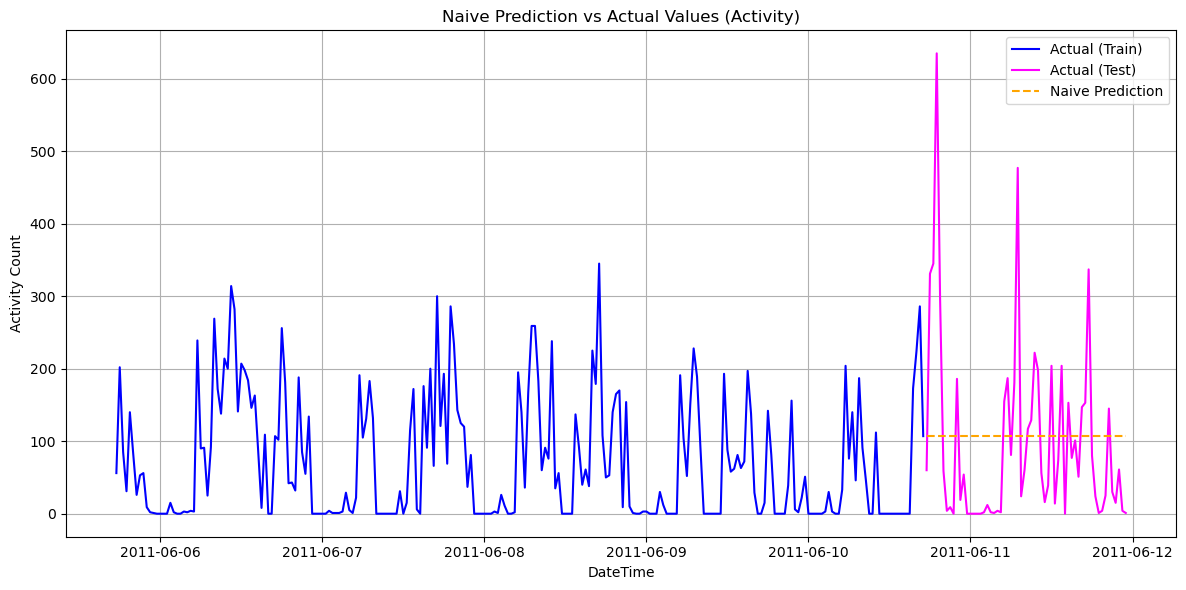

Root Mean Squared Error (RMSE) on test set (Temperature): 2.0831666599994665
Root Mean Squared Error (RMSE) on test set (Activity): 127.32687592701446


In [242]:
# Splitting the DataFrame into 80/20 ratio
# Causes train and test DataFrame to be mixed. Shifting DateTime results in wrong (?) naive prediction
# train_t001_1h, test_t001_1h = train_test_split(df_t001_1h, test_size=0.2, random_state=42)

df_t001_1h = df_t001_1h.sort_values(by="DateTime_ISO8601").reset_index(drop=True)
df_activity_30m = df_activity_30m.sort_values(by="DateTime_ISO8601").reset_index(drop=True)
_df_t001_1h, _df_activity_30m = df_t001_1h[-range_limit:], df_activity_30m[-range_limit:]

# Split into train and test (80/20)
split_index = int(len(_df_t001_1h) * 0.8)
train_t001_1h, test_t001_1h = _df_t001_1h.iloc[0:split_index], _df_t001_1h.iloc[split_index:]
split_index = int(len(_df_activity_30m) * 0.8)
train_activity_30m, test_activity_30m = _df_activity_30m.iloc[0:split_index], _df_activity_30m.iloc[split_index:]

# Prepare test set with predictions
# Use the last value of train as the prediction for the test set

# Temperature DataFrame
last_train_value = train_t001_1h["Value_num"].iloc[-1]
test_t001_1h.loc[:, "naive_prediction"] = last_train_value
# Activity DataFrame
last_train_value = train_activity_30m["Activity"].iloc[-1]
test_activity_30m.loc[:, "naive_prediction"] = last_train_value

# Visualization (Temperature)
plt.figure(figsize=(12, 6))
plt.plot(train_t001_1h["DateTime_ISO8601"], train_t001_1h["Value_num"], label="Actual (Train)", color="blue")
plt.plot(test_t001_1h["DateTime_ISO8601"], test_t001_1h["Value_num"], label="Actual (Test)", color="magenta")
plt.plot(
    test_t001_1h["DateTime_ISO8601"],
    test_t001_1h["naive_prediction"],
    label="Naive Prediction",
    color="orange",
    linestyle="--",
)

plt.title("Naive Prediction vs Actual Values (Temperature)")
plt.xlabel("DateTime")
plt.ylabel("Temperature in °C")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Visualization (Activity)
plt.figure(figsize=(12, 6))
plt.plot(train_activity_30m["DateTime_ISO8601"], train_activity_30m["Activity"], label="Actual (Train)", color="blue")
plt.plot(test_activity_30m["DateTime_ISO8601"], test_activity_30m["Activity"], label="Actual (Test)", color="magenta")
plt.plot(
    test_activity_30m["DateTime_ISO8601"],
    test_activity_30m["naive_prediction"],
    label="Naive Prediction",
    color="orange",
    linestyle="--",
)

plt.title("Naive Prediction vs Actual Values (Activity)")
plt.xlabel("DateTime")
plt.ylabel("Activity Count")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Calculate Root Mean Squared Error (RMSE)
rmse = calculate_rmse(test_t001_1h["Value_num"], test_t001_1h["naive_prediction"])
print(f"Root Mean Squared Error (RMSE) on test set (Temperature): {rmse}")

rmse = calculate_rmse(test_activity_30m["Activity"], test_activity_30m["naive_prediction"])
print(f"Root Mean Squared Error (RMSE) on test set (Activity): {rmse}")

##### ÜBUNG: EINFACHE VORHERSAGE (SEASONAL NAIVE)
- Domänenwissen:
    - Datenintervall: 30m bzw 1h (Activity bzw Temperatur)
    - $\Rightarrow$ Betrachtung für jeweils einen Tag (24h Season)

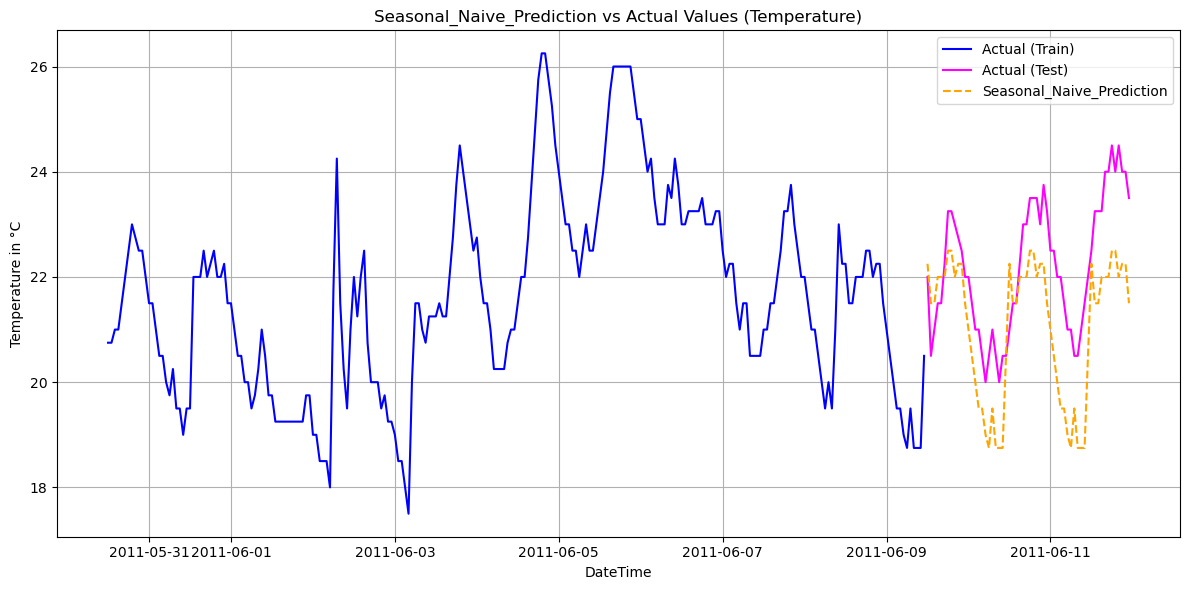

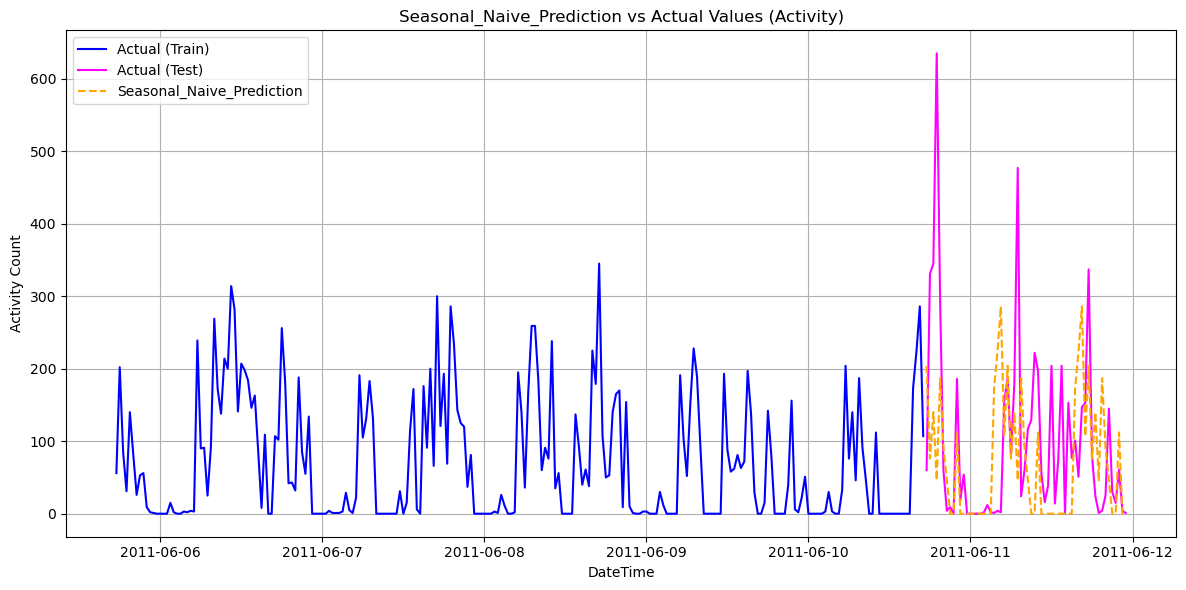

Root Mean Squared Error (RMSE) on test set (Temperature): 1.4458993740921255
Root Mean Squared Error (RMSE) on test set (Activity): 142.4184562009667


In [243]:
# Define seasonal lag (24 hours for daily seasonality in hourly data)
seasonal_lag = 24

df_t001_1h = df_t001_1h.sort_values(by="DateTime_ISO8601").reset_index(drop=True)
df_activity_30m = df_activity_30m.sort_values(by="DateTime_ISO8601").reset_index(drop=True)
_df_t001_1h, _df_activity_30m = df_t001_1h[-range_limit:], df_activity_30m[-range_limit:]

# Split into train and test (80/20)
split_index = int(len(_df_t001_1h) * 0.8)
train_t001_1h, test_t001_1h = _df_t001_1h.iloc[0:split_index], _df_t001_1h.iloc[split_index:]
split_index = int(len(_df_activity_30m) * 0.8)
train_activity_30m, test_activity_30m = _df_activity_30m.iloc[0:split_index], _df_activity_30m.iloc[split_index:]

# Temperature DataFrame
test_t001_1h["Seasonal_Naive_Prediction"] = pd.Series(dtype="int")
seasonal_data = train_t001_1h["Value_num"].iloc[-seasonal_lag:].to_list()
for i in range(0, len(test_t001_1h.index)):
    new_snp_entry = seasonal_data[i % len(seasonal_data)]  # Use modulo to prevent IndexError
    test_t001_1h.loc[test_t001_1h.index.start + i, "Seasonal_Naive_Prediction"] = new_snp_entry
# Activity DataFrame
test_activity_30m["Seasonal_Naive_Prediction"] = pd.Series(dtype="int")
seasonal_data = train_activity_30m["Activity"].iloc[-seasonal_lag:].to_list()
for i in range(0, len(test_activity_30m.index)):
    new_snp_entry = seasonal_data[i % len(seasonal_data)]  # Use modulo to prevent IndexError
    test_activity_30m.loc[test_activity_30m.index.start + i, "Seasonal_Naive_Prediction"] = new_snp_entry

# Visualization (Temperature)
plt.figure(figsize=(12, 6))
plt.plot(train_t001_1h["DateTime_ISO8601"], train_t001_1h["Value_num"], label="Actual (Train)", color="blue")
plt.plot(test_t001_1h["DateTime_ISO8601"], test_t001_1h["Value_num"], label="Actual (Test)", color="magenta")
plt.plot(
    test_t001_1h["DateTime_ISO8601"],
    test_t001_1h["Seasonal_Naive_Prediction"],
    label="Seasonal_Naive_Prediction",
    color="orange",
    linestyle="--",
)

plt.title("Seasonal_Naive_Prediction vs Actual Values (Temperature)")
plt.xlabel("DateTime")
plt.ylabel("Temperature in °C")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Visualization (Activity)
plt.figure(figsize=(12, 6))
plt.plot(train_activity_30m["DateTime_ISO8601"], train_activity_30m["Activity"], label="Actual (Train)", color="blue")
plt.plot(test_activity_30m["DateTime_ISO8601"], test_activity_30m["Activity"], label="Actual (Test)", color="magenta")
plt.plot(
    test_activity_30m["DateTime_ISO8601"],
    test_activity_30m["Seasonal_Naive_Prediction"],
    label="Seasonal_Naive_Prediction",
    color="orange",
    linestyle="--",
)

plt.title("Seasonal_Naive_Prediction vs Actual Values (Activity)")
plt.xlabel("DateTime")
plt.ylabel("Activity Count")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Calculate Root Mean Squared Error (RMSE)
rmse = calculate_rmse(test_t001_1h["Value_num"], test_t001_1h["Seasonal_Naive_Prediction"])
print(f"Root Mean Squared Error (RMSE) on test set (Temperature): {rmse}")

rmse = calculate_rmse(test_activity_30m["Activity"], test_activity_30m["Seasonal_Naive_Prediction"])
print(f"Root Mean Squared Error (RMSE) on test set (Activity): {rmse}")